
# 🔍 Diagnostic Analytics: Root Cause of Late Deliveries

**Goal:** Investigate *why* deliveries were late and which process stages contributed most.

**You will:**
1️⃣ Simulate timestamps for each stage (pick, depart, customs, linehaul, delivery)  
2️⃣ Compute which stage caused the delay  
3️⃣ Visualize a **Pareto-style bar chart** of delay causes and a **lead-time decomposition plot**

💡 *Use case:* You are a logistics analyst at **Maersk** diagnosing where delays occur in the delivery chain.



---
## ⚙️ 1️⃣ Simulate Shipment Process Stages
Each shipment passes through stages: **Pick → Depart → Customs → Linehaul → LastMile**.
We'll simulate realistic durations for 500 shipments across Air, Road, and Sea modes.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# --- Create staged event dataset ---
N = 500
mode = rng.choice(["Road","Air","Sea"], p=[0.6,0.2,0.2], size=N)
order_day = pd.to_datetime("2025-01-01") + pd.to_timedelta(rng.integers(0,60,size=N), unit="D")

# Stage durations (in days) with mode effects
pick = rng.normal(0.5, 0.2, size=N).clip(0.1,2.0)
depart = rng.normal(0.2, 0.1, size=N).clip(0.05,1.0)
customs = np.where(mode=="Sea", rng.normal(3.0,1.2,size=N), rng.normal(0.6,0.4,size=N)).clip(0,8)
linehaul = np.where(mode=="Air", rng.normal(1.8,0.5,size=N),
            np.where(mode=="Road", rng.normal(3.0,1.0,size=N), rng.normal(10,3,size=N))).clip(0.5,20)
lastmile = rng.normal(0.7,0.3,size=N).clip(0.2,3.0)

lead = pick+depart+customs+linehaul+lastmile
sla = np.where(mode=="Air", 4, np.where(mode=="Road", 7, 18))
late = lead > sla

stages = pd.DataFrame({
    "Mode": mode, "OrderDate": order_day,
    "Pick": pick.round(2), "Depart": depart.round(2),
    "Customs": customs.round(2), "Linehaul": linehaul.round(2),
    "LastMile": lastmile.round(2), "LeadTime": lead.round(2),
    "SLA": sla, "Late": late
})

stages.head()


,Mode,OrderDate,Pick,Depart,Customs,Linehaul,LastMile,LeadTime,SLA,Late
0,Air,2025-03-01,0.20,0.27,0.64,1.63,0.20,2.93,4,False
1,Sea,2025-01-26,0.56,0.05,3.97,10.92,0.20,15.70,18,False
2,Air,2025-01-17,0.48,0.19,0.31,1.54,0.94,3.45,4,False
3,Road,2025-02-19,0.44,0.23,1.35,1.81,0.91,4.74,7,False
4,Road,2025-01-28,0.49,0.16,0.12,2.35,0.20,3.31,7,False



---
## 🧩 2️⃣ Identify Root Causes of Delay
We benchmark each stage’s expected duration and flag the stage with the **largest excess time** as the main delay contributor.


In [2]:

# Benchmarks (expected duration in days)
bench = {"Pick":0.6, "Depart":0.3, "Customs":1.0, "Linehaul":2.5, "LastMile":0.8}

def root_cause(row):
    overs = {s: row[s]-bench[s] for s in bench if row[s] > bench[s]}
    return max(overs, key=overs.get) if overs else "None"

stages["RootCause"] = stages.apply(root_cause, axis=1)

# Pareto table: count of late shipments by root cause
pareto = (stages[stages["Late"]]
          ["RootCause"].value_counts()
          .rename_axis("Cause")
          .reset_index(name="LateCount"))

pareto


,Cause,LateCount
0,Linehaul,26
1,LastMile,17
2,Pick,7
3,Customs,6
4,None,5
5,Depart,1



---
## 📊 3️⃣ Visualize Delay Drivers
Two useful diagnostic views:
- **Pareto Chart** of delay causes (which stages matter most)  
- **Lead Time Distribution** by transport mode (boxplot)


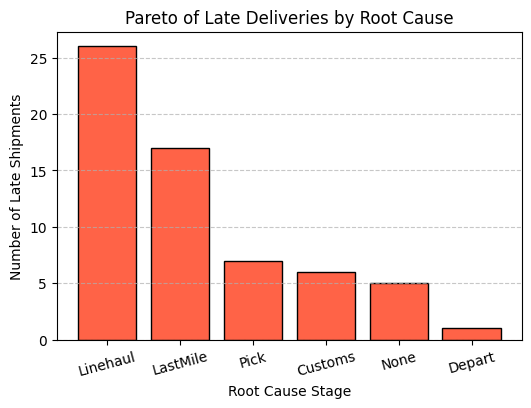

In [3]:

# --- Pareto Chart ---
plt.figure(figsize=(6,4))
plt.bar(pareto["Cause"], pareto["LateCount"], color="tomato", edgecolor="black")
plt.title("Pareto of Late Deliveries by Root Cause")
plt.ylabel("Number of Late Shipments")
plt.xlabel("Root Cause Stage")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


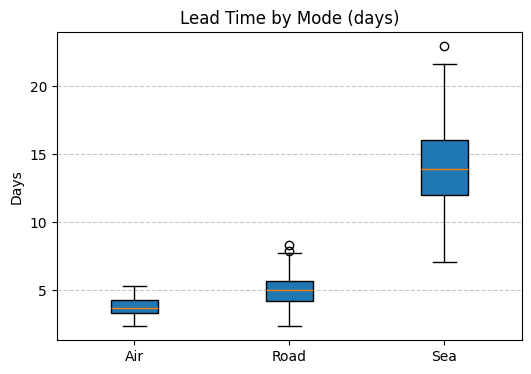

In [4]:

# --- Lead-Time Distribution by Mode ---
plt.figure(figsize=(6,4))
data = [stages.loc[stages["Mode"]==m, "LeadTime"] for m in ["Air","Road","Sea"]]
plt.boxplot(data, labels=["Air","Road","Sea"], patch_artist=True)
plt.title("Lead Time by Mode (days)")
plt.ylabel("Days")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



---
## ✅ Interpretation

- **Customs** and **Linehaul** stages often dominate delay causes, especially for Sea shipments.  
- **Air** tends to stay within SLA, but **Road** can vary depending on congestion or handovers.  
- Pareto analysis highlights that fixing 1–2 key bottlenecks can resolve most delays.

🔍 *Diagnostic analytics* explains *why* delays occur — the foundation for **Prescriptive decisions** later (e.g., re-route, expedite, or renegotiate SLAs).


Overall OTIF: 87.6%

OTIF by Mode (%):
Mode
Air     59.8
Road    97.3
Sea     87.5
Name: OTIF_%, dtype: float64


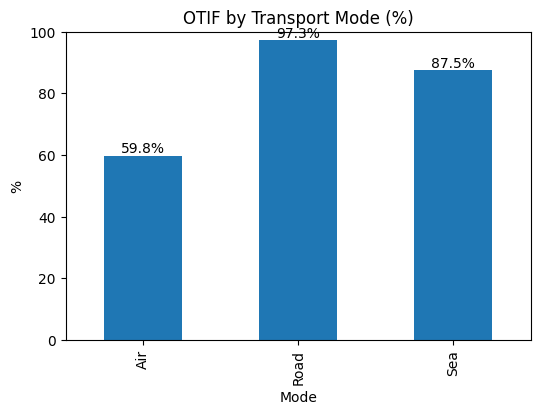

In [5]:
# === OTIF (On-Time In-Full) — simplified to On-Time since we don't track quantities ===
# On-Time when actual lead time meets or beats the SLA
stages["OnTime"] = stages["LeadTime"] <= stages["SLA"]

# Overall OTIF (%)
otif_overall = stages["OnTime"].mean() * 100
print(f"Overall OTIF: {otif_overall:.1f}%")

# OTIF by transport mode (%)
otif_by_mode = (
    stages.groupby("Mode")["OnTime"]
          .mean()
          .mul(100)
          .round(1)
          .rename("OTIF_%")
)
print("\nOTIF by Mode (%):")
print(otif_by_mode)

# Quick visual
ax = otif_by_mode.plot(kind="bar", figsize=(6,4))
ax.set_title("OTIF by Transport Mode (%)")
ax.set_ylabel("%")
ax.set_xlabel("Mode")
ax.set_ylim(0,100)
for i,v in enumerate(otif_by_mode.values):
    ax.text(i, v+1, f"{v:.1f}%", ha="center")
plt.show()
